## CNN Audio Classification based on Filter Banks.

In [3]:
import sys
import os
sys.path.append("..") # Adds higher directory to python modules path. This is important to load the libraries  in PROJECT_HOME/src/
import src.d01_load_data as ld #Library to load data and handle data.

speakers = ["84","174","251","422"]
#PROJECT_HOME = os.getcwd()+"/"
# NOTE that in this Jupyter notebook, the parent folder is the project home, not this!
PROJECT_HOME = os.path.dirname(os.getcwd())+"/"

SI_DATA="Speaker Identification/data/" #Speaker identification dataset.
#SI_DATA="Speaker Identification/data_test/" #Speaker identification dataset.

### Reading Audio and showing it.

C:\Users\ece_a\Anaconda3\lib\site-packages\librosa\effects.py:490: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[full_index], np.asarray([start, end])


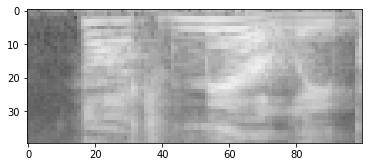

In [4]:
#sAudio = ld.Audio(PROJECT_HOME+SI_DATA+"84/84-121550-0035.flac")
sAudio = ld.Audio(PROJECT_HOME+SI_DATA+"174/174-84280-0015.flac")
sAudio.read()
#Preprocessing Audio 
sFilBank = sAudio.transformToFilterBank(N=1.0,trimSilence=True)
sAudio.showSpectogramImage(sFilBank[2].T)

In [5]:
dataSI = ld.DataLoader(PROJECT_HOME,SI_DATA,speakers)
filesP,filesL = dataSI.getAllFilesPath()
dTrain,lTrain, dTest, lTest = dataSI.splitTrainingTest(filesP,filesL,splitSizeTest=0.30,shuffle=True) #Shuffle before getting the Training/Test


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm

class DatasetAudio(Dataset):
  def __init__(self,files,labels,categories):
    self.data=[]
    self.labels = labels #A list of the labels in numerical.
    self.categories = categories
    self.input_shape = [0,0,0] # Define the shape of the files
    self.sampleRates = []
    self.samples = []
    self.seconds = []
    nFiles = len(files)
    tmpLabels = []
    for i in tqdm(range(0, nFiles)):
        fAudio = ld.Audio(files[i])
        samp, sr = fAudio.read()
        self.samples.append(len(samp))
        self.sampleRates.append(sr)
        self.seconds.append(len(samp)/sr)

        sFilBank_list = sAudio.transformToFilterBank(N=1.0,trimSilence=True)        
        for sImage in sFilBank_list:
          sImage = sImage.T #Important! The image should have as first axis the filters and as second the features itself.
          self.data.append(sImage[np.newaxis,...])#Transform in 3D with a new axis.
          tmpLabels.append(self.labels[i])
    # Reassign the expanded labels
    self.labels = tmpLabels

  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]
print("Reading Training Data")
train_data = DatasetAudio(dTrain,lTrain,speakers)
print("Reading Testing Data")
valid_data = DatasetAudio(dTest,lTest,speakers)

Reading Training Data


C:\Users\ece_a\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\ece_a\Anaconda3\lib\site-packages\librosa\effects.py:490: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[full_index], np.asarray([start, end])



Reading Testing Data


In [7]:
#Statistics of the dataset:
import pandas as pd

dfSI = pd.DataFrame(list(zip(lTrain,train_data.samples,train_data.sampleRates,train_data.seconds,dTrain)),columns=["Category","Samples Length","Sample Rate","Seconds","Path"])
dfSI.head(10)

Category  Samples Length  Sample Rate    Seconds  \
0         1          137760        16000   8.610000   
1         1           53680        16000   3.355000   
2         0           41760        16000   2.610000   
3         2           70400        16000   4.400000   
4         3          203040        16000  12.690000   
5         2           45280        16000   2.830000   
6         0          130560        16000   8.160000   
7         2           79360        16000   4.960000   
8         0          138080        16000   8.630000   
9         0           43121        16000   2.695063   

                                                Path  
0  C:\Users\ece_a\Desktop\Github\studentproject/S...  
1  C:\Users\ece_a\Desktop\Github\studentproject/S...  
2  C:\Users\ece_a\Desktop\Github\studentproject/S...  
3  C:\Users\ece_a\Desktop\Github\studentproject/S...  
4  C:\Users\ece_a\Desktop\Github\studentproject/S...  
5  C:\Users\ece_a\Desktop\Github\studentproject/S...  
6  C:\Users\ece_a\Desktop\Github\studentproject/S...  
7  C:\Users\ece_a\Desktop\Github\studentproject/S...  
8  C:\Users\ece_a\Desktop\Github\studentproject/S...  
9  C:\Users\ece_a\Desktop\Github\studentproject/S...

In [8]:
dfSI.describe()

Category  Samples Length  Sample Rate     Seconds
count  165.000000      165.000000        165.0  165.000000
mean     1.387879   131881.709091      16000.0    8.242607
std      1.045244    89517.734817          0.0    5.594858
min      0.000000    24560.000000      16000.0    1.535000
25%      0.000000    66720.000000      16000.0    4.170000
50%      1.000000   111760.000000      16000.0    6.985000
75%      2.000000   157440.000000      16000.0    9.840000
max      3.000000   519040.000000      16000.0   32.440000

In [142]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=10, shuffle=False)

Input shape

In [143]:
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

#If there are cuda problems, direct everything to the cpu.
#device=torch.device('cpu')
print(device)

cuda:0


## Defining Network Architecture

In [144]:
#defining the network and the training parts are inspired by [1], [3] and [4]

class Net(nn.Module):
    def __init__(self,input_shape, num_cats):
        
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2,stride=2)
        #self.bn1  = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2,stride=2)
        #self.bn2  = nn.BatchNorm2d(32)        
        #self.dense1 = nn.Linear(32*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2),64)
        #self.fc1 = nn.Linear(32*(((input_shape[1]//2)//2))*(((input_shape[2]//2)//2)),120)
        self.fc1 = nn.Linear(64*154,60)
        #self.fc1   = nn.Linear(256,60)
        self.fc2   = nn.Linear(60,num_cats)
        #self.fc3   = nn.Linear(64,num_cats)
        #self.dropout = nn.Dropout(0.5)
        #self.dense2 = nn.Linear(64, num_cats)
        
    #defining forward pass
    def forward(self, x):
        #running layer1
        x = self.conv1(x)
        #x = F.relu(self.bn1(x))
        x = F.relu(x)
        x = self.pool1(x)
        #running layer2  
        x = self.conv2(x)
        #x = F.relu(self.bn2(x))
        x = F.relu(x)
        x = self.pool2(x)
        #running Hidden Layers
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        """
        x = F.relu(x)        
        #x = self.dropout(x)
        x = self.fc3(x) 
        """

        return x


In [145]:
#defining the network and the training parts are inspired by [1], [3] and [4]

class Net2(nn.Module):
    def __init__(self,input_shape, num_cats):
        
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size = 8)
        self.bn1 = nn.BatchNorm2d(128)

        self.conv2 = nn.Conv2d(128, 256, kernel_size = 5)      
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(256, 128, kernel_size = 3)        
        self.bn2 = nn.BatchNorm2d(256)

        self.pool = nn.AvgPool2d(2)
        self.soft = nn.Softmax()
        
    #defining forward pass
    def forward(self, x):
        

        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        #x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        #x = F.relu(x)
        
        x = self.pool(x)
        x = x.view(x.size(0),-1)
        x = self.soft(x)
                
        return x


In [146]:
model = Net2(train_data.input_shape,len(train_data.categories)).to(device)
# Cross Entrophy and optimizer with SGD
loss_fn = nn.CrossEntropyLoss()
num_epochs = 10
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [147]:
loss_train_epoch = []
loss_train_epoch = []

acc_test_epoch = []
loss_test_epoch = []

batch_losses = []
train_losses = []
valid_losses = []

for epoch in tqdm(range(1,num_epochs+1)):
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    loss_train_epoch.append(np.mean(train_losses[-1]))
    ##Test
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')    
    loss_test_epoch.append(np.mean(valid_losses[-1]))
    acc_test_epoch.append(accuracy)
    print("")

C:\Users\ece_a\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


C:\Users\ece_a\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch - 1 Train-Loss : 11.957854952131
Epoch - 1 Valid-Loss : 11.948450098232348 Valid-Accuracy : 0.044897959183673466

Epoch - 2 Train-Loss : 11.917467685455971
Epoch - 2 Valid-Loss : 11.876614755513717 Valid-Accuracy : 0.09387755102040816

Epoch - 3 Train-Loss : 11.875417425277385
Epoch - 3 Valid-Loss : 11.874694104097328 Valid-Accuracy : 0.09387755102040816

Epoch - 4 Train-Loss : 11.874342373439244
Epoch - 4 Valid-Loss : 11.874610511624084 Valid-Accuracy : 0.09387755102040816

Epoch - 5 Train-Loss : 11.874268352079536
Epoch - 5 Valid-Loss : 11.87458541441937 Valid-Accuracy : 0.09387755102040816



KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(loss_train_epoch)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(loss_test_epoch,'orange')
plt.legend(['Valid Loss'])

## References:
- https://medium.com/@hasithsura/audio-classification-d37a82d6715